In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### **Importing Libraries**

In [1]:
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sb
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from transformers import DistilBertTokenizerFast, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used: {}".format(device))

Device used: cuda


In [2]:
# Initialising the Variables
num_classes=5
n_workers=2

### **Dataset and EDA**

In [3]:
# Reading dataset
clinical_notes=pd.read_csv('/kaggle/input/clinical-notes-nlp/clinical_notes.csv')
clinical_notes.drop(['Unnamed: 0'],axis=1,inplace=True)
print("Shape of the data: {}".format(clinical_notes.shape))
print("Columns:{}".format(clinical_notes.columns))
clinical_notes.head()

Shape of the data: (2289, 2)
Columns:Index(['medical_specialty', 'transcription'], dtype='object')


,medical_specialty,transcription
0,neurology,"PROCEDURE:, A 21-channel digital electroenceph..."
1,neurology,"REASON FOR VISIT:, post-current visit for cran..."
2,radiology,"EXAMINATION:, Nuclear medicine lymphatic explo..."
3,neurology,HISTORY OF PRESENT ILLNESS: Patient is a 36-ye...
4,radiology,"REVIEW:, LEFT SHOULDER MRI, CLINICAL:, Est is ..."


In [4]:
# Finding the null values
clinical_notes.isnull().sum()

medical_specialty    0
transcription        0
dtype: int64

In [5]:
# Droping the duplicate rows
clinical_notes.drop_duplicates()

,medical_specialty,transcription
0,neurology,"PROCEDURE:, A 21-channel digital electroenceph..."
1,neurology,"REASON FOR VISIT:, post-current visit for cran..."
2,radiology,"EXAMINATION:, Nuclear medicine lymphatic explo..."
3,neurology,HISTORY OF PRESENT ILLNESS: Patient is a 36-ye...
4,radiology,"REVIEW:, LEFT SHOULDER MRI, CLINICAL:, Est is ..."
...,...,...
2284,gastroenterology,"PREOPERATIVE DIAGNOSIS: , Recurrent re-infecte..."
2285,gastroenterology,"CHIEF COMPLAINT: , Nausea.,PRESENT ILLNESS: , ..."
2286,gastroenterology,"PREOPERATIVE DIAGNOSIS: , Acute appendicitis.,..."
2287,gastroenterology,"PREOPERATIVE DIAGNOSIS: , Abdominal wall absce..."


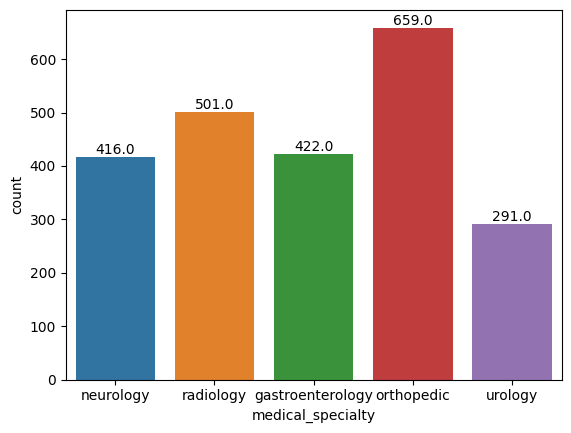

In [6]:
# Countplot of the label data
sb.countplot(x=clinical_notes['medical_specialty'])
# Add annotations to the count plot
ax = plt.gca()  # Get the current axes
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', 
                va='bottom')

### **Data Preprcessing**

In [7]:
# Installing the necessary libraries
import re
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_d

In [8]:
# Downloading the stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")
removing_words=['aren','no','nor','not','ain',"aren't",'don',"don't",'couldn',"couldn't",'didn',"didn't",
                'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",'ma',
                'mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'shan',"shan't",'shouldn',
                "shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't"]

# Removing necessary words frm removing_words
for i in removing_words:
    stopwords.remove(i)
    
# Removing unecesaary characters from transcription    
def text_preprocess(desc):
    description=re.sub('[^a-zA-Z0-9]',' ',desc)
    sent = ' '.join(e for e in description.split() if e not in stopwords)
    return sent.lower().strip()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Word Lemmetising
tqdm.pandas()
clinical_notes['transcription']=clinical_notes['transcription'].progress_apply(lambda x:text_preprocess(x))
clinical_notes['transcription']=clinical_notes['transcription'].progress_apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(word) for word in x.split() if word not in stopwords]))
clinical_notes.head()

100%|██████████| 2289/2289 [00:06<00:00, 329.44it/s]


,medical_specialty,transcription
0,neurology,procedure 21 channel digital electroencephalog...
1,neurology,reason visit post current visit craniopharyngi...
2,radiology,examination nuclear medicine lymphatic explora...
3,neurology,history present illness patient 36 year old fe...
4,radiology,review left shoulder mri clinical est 51 year ...


### **BERT Feature Extraction**

In [10]:
# Defining the custom dataset for loading and preproccessing
class DataTokenising(Dataset):
    def __init__(self,data):
        self.data=data
        self.tokenizer=DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

    def __len__(self):
        return len(self.data)

    def __getitem__(self,index):
        text=self.data[index]
        encoding = self.tokenizer.encode_plus(text,
                                              max_length=512, 
                                              return_tensors='pt',
                                              padding='max_length',
                                              truncation=True)
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return input_ids, attention_mask

# Defining class for BERT feature extraction
class BERTExtraction(torch.nn.Module):
    def __init__(self):
        super(BERTExtraction,self).__init__()
        self.distilled_bert=DistilBertModel.from_pretrained('distilbert-base-uncased')

    def forward(self,input_ids,attention_mask):
        outputs = self.distilled_bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs[0]

In [11]:
# Loading the data to DataLoaders
transcription=clinical_notes['transcription'].tolist()
data_tokenising=DataTokenising(transcription)
token_dataloader=DataLoader(data_tokenising,shuffle=False,num_workers=2)

# BERT Feature Extraction
BERT_FeatExtraction = BERTExtraction().to(device)  # Set up the model and move it to the GPU

# Iterate through the data using the dataloader and perform BERT feature extraction in parallel
bert_features = []
for input_ids, attention_mask in tqdm(token_dataloader):
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = BERT_FeatExtraction(input_ids, attention_mask)

    bert_features.append(outputs.cpu().numpy())
    
print("Number of samples: {}".format(len(bert_features)))
print("Shape of ech sample : {}".format(bert_features[0].shape))
torch.cuda.empty_cache()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 2289/2289 [00:48<00:00, 47.48it/s]

Number of samples: 2289
Shape of ech sample : (1, 512, 768)


### **Train Test Split**

In [12]:
# Seperating the data into train and test
y=clinical_notes[['medical_specialty']]
train_x,test_x,s_train_y,s_test_y=train_test_split(bert_features, y, test_size=0.2, random_state=100,stratify=y)
print("Number of samples in train data : {}".format(len(train_x)))
print("Number of samples in test data : {}".format(len(test_x)))

Number of samples in train data : 1831
Number of samples in test data : 458


### **Train and Validation Split**

In [13]:
# Seperating data into 1 split -> Train and validation
train_x,val_x,s_train_y,s_val_y=train_test_split(train_x, s_train_y, 
                                                 test_size=0.1, 
                                                 random_state=10,
                                                 stratify=s_train_y[['medical_specialty']])
print("Number of samples in train data : {}".format(len(train_x)))
print("Number of samples in val data : {}".format(len(val_x)))

Number of samples in train data : 1647
Number of samples in val data : 184


In [14]:
class_counts=s_train_y['medical_specialty'].value_counts()
class_counts

orthopedic          474
radiology           361
gastroenterology    303
neurology           299
urology             210
Name: medical_specialty, dtype: int64

In [15]:
# Convertng the labels to vectors

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(s_train_y[['medical_specialty']])
categories=ohe.categories_

train_y = ohe.transform(s_train_y)
val_y=ohe.transform(s_val_y)
test_y = ohe.transform(s_test_y)
print(train_y)

[[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [16]:
total_samples=len(train_y)
class_weights=[total_samples/(5*class_counts[i]) for i in categories[0]]
print(class_weights)

[1.0871287128712872, 1.1016722408026756, 0.6949367088607595, 0.9124653739612189, 1.5685714285714285]


#### **Considering CLS unit**

In [17]:
class FeaturesCLSUnit(Dataset):
    def __init__(self,x,y):
        self.n_samples=len(x)
        self.x_data=x
        self.y_data=y
        
    def __getitem__(self,index):
        return self.x_data[index][:,0,:],self.y_data[index]
    
    def __len__(self):
        return self.n_samples

In [18]:
train_dataloader1=DataLoader(FeaturesCLSUnit(train_x,train_y),shuffle=False,num_workers=2,batch_size=8)
val_dataloader1=DataLoader(FeaturesCLSUnit(val_x,val_y),shuffle=False,num_workers=2,batch_size=len(val_y))
test_dataloader=DataLoader(FeaturesCLSUnit(test_x,test_y),shuffle=False,num_workers=2,batch_size=len(test_y))
dataiter1=iter(train_dataloader1)
print(next(dataiter1)[0].shape)

torch.Size([8, 1, 768])


In [19]:
class Metrics:
    def __init__(self,y_pred,y_true,batch_size):
        self.y_pred=y_pred
        self.y_true=y_true
        self.batch_size=batch_size
        
    def True_Positives(self):
        TP=0
        for label in range(num_classes):
            fill_label=torch.full((self.batch_size,),label).to(device)
            TP += ((self.y_pred.argmax(dim=1) == fill_label) & (self.y_true.argmax(dim=1) == fill_label)).sum().item()
        return TP

    def True_Negatives(self):
        TN=0
        for label in range(num_classes):
            fill_label=torch.full((self.batch_size,),label).to(device)
            TN += ((self.y_pred.argmax(dim=1) != fill_label) & (self.y_true.argmax(dim=1) != fill_label)).sum().item()
        return TN
    
    def False_Positives(self):
        FP=0
        for label in range(num_classes):
            fill_label=torch.full((self.batch_size,),label).to(device)
            FP += ((self.y_pred.argmax(dim=1) == fill_label) & (self.y_true.argmax(dim=1) != fill_label)).sum().item()
        return FP
    
    def False_Negatives(self):
        FN=0
        for label in range(num_classes):
            fill_label=torch.full((self.batch_size,),label).to(device)
            FN += ((self.y_pred.argmax(dim=1) != fill_label) & (self.y_true.argmax(dim=1) == fill_label)).sum().item()
        return FN
    
    

In [20]:
class CLSNN(nn.Module):
    def __init__(self,input_size,concat=None):
        super(CLSNN,self).__init__()
        self.network=nn.Sequential(
            nn.Linear(input_size,640),nn.LeakyReLU(),
            nn.Linear(640,512),nn.BatchNorm1d(1),nn.LeakyReLU(),#,nn.Dropout(p=0.2),
            nn.Linear(512,216),nn.BatchNorm1d(1),nn.LeakyReLU(),#,nn.Dropout(p=0.2),
            nn.Linear(216,216),nn.BatchNorm1d(1),nn.LeakyReLU(),#,nn.Dropout(p=0.2),
            nn.Linear(216,128),nn.BatchNorm1d(1),nn.LeakyReLU(),#,nn.Dropout(p=0.2),
            nn.Linear(128,64),nn.BatchNorm1d(1),nn.LeakyReLU(),
            nn.Linear(64,32),nn.BatchNorm1d(1),nn.LeakyReLU(),
            nn.Linear(32,16),nn.BatchNorm1d(1),nn.LeakyReLU(),#nn.Dropout(p=0.2),
            nn.Linear(16,10),nn.BatchNorm1d(1),nn.LeakyReLU(),
            nn.Linear(10,5)
        )
        
        for module in self.network.modules():
            if isinstance(module,nn.Linear):
                init.kaiming_uniform_(module.weight)
                init.zeros_(module.bias)
                
            
        
    def forward(self,x):
        out=self.network(x)
        return out

In [21]:
def TestMetrics(test_dataloader,model):
    
    criterion = nn.CrossEntropyLoss()
    for features,target in test_dataloader:
        features,target = features.to(device), target.to(device)
        y_pred=model(features)
        y_pred=y_pred.squeeze()
        target=target.squeeze()
        ce = criterion(y_pred,target)
        metrics=Metrics(y_pred,target,len(features))
        tp = metrics.True_Positives()
        tn = metrics.True_Negatives()
        fp = metrics.False_Positives()
        fn = metrics.False_Negatives()
        
        accuracy = (tp + tn) / (tp + tn + fp + fn)  
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        f1_score = (2*precision*recall) / (precision + recall)
        print(f"Test_Cross-entropy={float(ce) : .04}, Test_Accuracy={float(accuracy):.04}",end=", ")
        print(f"Test_Recall={float(recall): .04}",end=', ')
        print(f"Test_Precision={float(precision):.04}",end=', ')
        print(f"Test_F1_score={float(f1_score):.04}")


In [22]:
def ModelTraining(train_dataloader=None,val_dataloader=None,test_dataloader=None,nn_model=None,epochs=5):
    
    model=nn_model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.3, patience=3,min_lr=1e-5, verbose=True)
    weight_tensor = torch.FloatTensor(class_weights).to(device)
    criterion = nn.CrossEntropyLoss(weight=weight_tensor)
    early_stop_patience=5
    count=0
    best_val_loss=float('inf')
    model_cpu=None

    for ep in range(1,epochs+1):
        
        # Training the model
        model.train()
        
        running_loss=0.0
        tp, tn, fp, fn = 0.0, 0.0, 0.0, 0.0
        batches=0

        with tqdm(train_dataloader,unit='batch') as tepoch:
            for features,target in tepoch:
                tepoch.set_description(f"Epoch {ep}")
                features,target=features.to(device),target.to(device)


                 # Forward pass
                outputs = model(features)
#                 print(outputs.shape)
#                 print(target.shape)
                loss = criterion(outputs.squeeze(), target)
                running_loss += loss
                
                metrics=Metrics(outputs.squeeze(),target,len(features))
                tp += metrics.True_Positives()
                tn += metrics.True_Negatives()
                fp += metrics.False_Positives()
                fn += metrics.False_Negatives()
                
#                 print(len(target))

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()

                # This helps in updating the weights
                optimizer.step() 
                tepoch.set_postfix(loss=loss.item())
                
                batches+=1
        
        # Training metrics
        accuracy = (tp + tn) / (tp + tn + fp + fn)  
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        f1_score = (2*precision*recall) / (precision + recall)
        print(f"Epoch {ep} Training: Cross-entropy={float(running_loss/batches) : .04}, accuaracy={float(accuracy) : .04}",end=", ")
        print(f"recall={float(recall) : .04}",end=', ')
        print(f"precision={float(precision) : .04}",end=', ')
        print(f"f1_score={float(f1_score) : .04}")

        # Validating the data
        model.eval()
        val_criterion=nn.CrossEntropyLoss()
        val_true_positives, val_true_negatives, val_false_positives, val_false_negatives= 0.0, 0.0, 0.0, 0.0
        for features,target in val_dataloader:
            features,target=features.to(device),target.to(device)
            val_y_pred=model(features)
            val_y_pred=val_y_pred.squeeze()
            target=target.squeeze()
            val_ce = val_criterion(val_y_pred,target)
            val_metrics=Metrics(val_y_pred,target,len(features))
            val_tp = val_metrics.True_Positives()
            val_tn = val_metrics.True_Negatives()
            val_fp = val_metrics.False_Positives()
            val_fn = val_metrics.False_Negatives()
            
        # Scheduler
        scheduler.step(val_ce)  
#         model_cpu =
        # Validation metrics
        val_accuracy = (val_tp + val_tn) / (val_tp + val_tn + val_fp + val_fn)  
        val_recall = val_tp / (val_tp + val_fn)
        val_precision = val_tp / (val_tp + val_fp)
        val_f1_score = (2*val_precision*val_recall) / (val_precision + val_recall)
        print(f"Epoch {ep} validation: val_Cross-entropy={float(val_ce) : .04}, val_accuracy={float(val_accuracy):.04}",end=", ")
        print(f"val_recall={float(val_recall): .04}",end=', ')
        print(f"val_precision={float(val_precision):.04}",end=', ')
        print(f"val_f1_score={float(val_f1_score):.04}",end=', ')
        print("Epoch:" + str(ep), "Learning Rate:" + str(optimizer.param_groups[0]['lr']))
        
        # Early Stopping 
        if val_ce<best_val_loss:
            best_val_loss=val_ce
            best_epoch=ep
            count=0
            
            if best_val_loss<1:
                checkpoint = {
                    'epoch': best_epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': best_val_loss
                }
                torch.save(checkpoint,f'best_model_epoch:{best_epoch}_loss:{best_val_loss:.04}')
            
        else:
            count+=1
            
        if count>=early_stop_patience:
            print("Early Stopping activated")
            break
            
    
    # Testing the data
    TestMetrics(test_dataloader,model)
        
        
            
#     best_model = early_stopping.best_model
            


In [24]:
ModelTraining(train_dataloader=train_dataloader1,
              val_dataloader=val_dataloader1,
              test_dataloader=test_dataloader,
              nn_model=CLSNN(768),
              epochs=20)
torch.cuda.empty_cache()

Epoch 1: 100%|██████████| 206/206 [00:03<00:00, 66.75batch/s, loss=1.25]


Epoch 1 Training: Cross-entropy= 1.574, accuaracy= 0.6957, recall= 0.2392, precision= 0.2392, f1_score= 0.2392
Epoch 1 validation: val_Cross-entropy= 1.625, val_accuracy=0.6739, val_recall= 0.1848, val_precision=0.1848, val_f1_score=0.1848, Epoch:1 Learning Rate:0.001


Epoch 2: 100%|██████████| 206/206 [00:03<00:00, 62.41batch/s, loss=1.18]

Epoch 2 Training: Cross-entropy= 1.428, accuaracy= 0.7292, recall= 0.323, precision= 0.323, f1_score= 0.323


Epoch 2 validation: val_Cross-entropy= 1.407, val_accuracy=0.7413, val_recall= 0.3533, val_precision=0.3533, val_f1_score=0.3533, Epoch:2 Learning Rate:0.001


Epoch 3: 100%|██████████| 206/206 [00:03<00:00, 61.72batch/s, loss=1.14] 

Epoch 3 Training: Cross-entropy= 1.366, accuaracy= 0.7576, recall= 0.394, precision= 0.394, f1_score= 0.394


Epoch 3 validation: val_Cross-entropy= 1.231, val_accuracy=0.8109, val_recall= 0.5272, val_precision=0.5272, val_f1_score=0.5272, Epoch:3 Learning Rate:0.001


Epoch 4: 100%|██████████| 206/206 [00:03<00:00, 60.38batch/s, loss=1.02] 

Epoch 4 Training: Cross-entropy= 1.298, accuaracy= 0.7705, recall= 0.4262, precision= 0.4262, f1_score= 0.4262


Epoch 4 validation: val_Cross-entropy= 1.175, val_accuracy=0.7804, val_recall= 0.4511, val_precision=0.4511, val_f1_score=0.4511, Epoch:4 Learning Rate:0.001


Epoch 5: 100%|██████████| 206/206 [00:03<00:00, 64.84batch/s, loss=0.826]


Epoch 5 Training: Cross-entropy= 1.213, accuaracy= 0.797, recall= 0.4924, precision= 0.4924, f1_score= 0.4924
Epoch 5 validation: val_Cross-entropy= 1.045, val_accuracy=0.8261, val_recall= 0.5652, val_precision=0.5652, val_f1_score=0.5652, Epoch:5 Learning Rate:0.001


Epoch 6: 100%|██████████| 206/206 [00:03<00:00, 66.99batch/s, loss=0.79] 

Epoch 6 Training: Cross-entropy= 1.151, accuaracy= 0.8072, recall= 0.5179, precision= 0.5179, f1_score= 0.5179


Epoch 6 validation: val_Cross-entropy= 1.016, val_accuracy=0.8152, val_recall= 0.538, val_precision=0.538, val_f1_score=0.538, Epoch:6 Learning Rate:0.001


Epoch 7: 100%|██████████| 206/206 [00:03<00:00, 64.03batch/s, loss=0.73] 


Epoch 7 Training: Cross-entropy= 1.105, accuaracy= 0.8113, recall= 0.5282, precision= 0.5282, f1_score= 0.5282
Epoch 7 validation: val_Cross-entropy= 1.002, val_accuracy=0.8239, val_recall= 0.5598, val_precision=0.5598, val_f1_score=0.5598, Epoch:7 Learning Rate:0.001


Epoch 8: 100%|██████████| 206/206 [00:03<00:00, 64.71batch/s, loss=0.711]

Epoch 8 Training: Cross-entropy= 1.07, accuaracy= 0.8203, recall= 0.5507, precision= 0.5507, f1_score= 0.5507


Epoch 8 validation: val_Cross-entropy= 1.247, val_accuracy=0.787, val_recall= 0.4674, val_precision=0.4674, val_f1_score=0.4674, Epoch:8 Learning Rate:0.001


Epoch 9: 100%|██████████| 206/206 [00:03<00:00, 66.61batch/s, loss=0.689]

Epoch 9 Training: Cross-entropy= 1.041, accuaracy= 0.8232, recall= 0.558, precision= 0.558, f1_score= 0.558


Epoch 9 validation: val_Cross-entropy= 0.9448, val_accuracy=0.8478, val_recall= 0.6196, val_precision=0.6196, val_f1_score=0.6196, Epoch:9 Learning Rate:0.001


Epoch 10: 100%|██████████| 206/206 [00:03<00:00, 63.00batch/s, loss=0.64] 

Epoch 10 Training: Cross-entropy= 1.006, accuaracy= 0.8385, recall= 0.5962, precision= 0.5962, f1_score= 0.5962


Epoch 10 validation: val_Cross-entropy= 1.003, val_accuracy=0.8196, val_recall= 0.5489, val_precision=0.5489, val_f1_score=0.5489, Epoch:10 Learning Rate:0.001


Epoch 11: 100%|██████████| 206/206 [00:03<00:00, 66.99batch/s, loss=0.687]


Epoch 11 Training: Cross-entropy= 0.9745, accuaracy= 0.8424, recall= 0.606, precision= 0.606, f1_score= 0.606
Epoch 11 validation: val_Cross-entropy= 0.9839, val_accuracy=0.8283, val_recall= 0.5707, val_precision=0.5707, val_f1_score=0.5707, Epoch:11 Learning Rate:0.001


Epoch 12: 100%|██████████| 206/206 [00:03<00:00, 61.34batch/s, loss=0.595]

Epoch 12 Training: Cross-entropy= 0.9506, accuaracy= 0.8487, recall= 0.6217, precision= 0.6217, f1_score= 0.6217


Epoch 12 validation: val_Cross-entropy= 0.9271, val_accuracy=0.8413, val_recall= 0.6033, val_precision=0.6033, val_f1_score=0.6033, Epoch:12 Learning Rate:0.001


Epoch 13: 100%|██████████| 206/206 [00:03<00:00, 60.43batch/s, loss=0.541]

Epoch 13 Training: Cross-entropy= 0.9072, accuaracy= 0.8567, recall= 0.6418, precision= 0.6418, f1_score= 0.6418


Epoch 13 validation: val_Cross-entropy= 1.023, val_accuracy=0.8304, val_recall= 0.5761, val_precision=0.5761, val_f1_score=0.5761, Epoch:13 Learning Rate:0.001


Epoch 14: 100%|██████████| 206/206 [00:03<00:00, 66.26batch/s, loss=0.508]

Epoch 14 Training: Cross-entropy= 0.8986, accuaracy= 0.8545, recall= 0.6363, precision= 0.6363, f1_score= 0.6363


Epoch 14 validation: val_Cross-entropy= 0.8919, val_accuracy=0.8457, val_recall= 0.6141, val_precision=0.6141, val_f1_score=0.6141, Epoch:14 Learning Rate:0.001


Epoch 15: 100%|██████████| 206/206 [00:03<00:00, 63.60batch/s, loss=0.493]

Epoch 15 Training: Cross-entropy= 0.8634, accuaracy= 0.8625, recall= 0.6563, precision= 0.6563, f1_score= 0.6563


Epoch 15 validation: val_Cross-entropy= 0.8772, val_accuracy=0.8565, val_recall= 0.6413, val_precision=0.6413, val_f1_score=0.6413, Epoch:15 Learning Rate:0.001


Epoch 16: 100%|██████████| 206/206 [00:03<00:00, 65.15batch/s, loss=0.506]

Epoch 16 Training: Cross-entropy= 0.8435, accuaracy= 0.8655, recall= 0.6636, precision= 0.6636, f1_score= 0.6636


Epoch 16 validation: val_Cross-entropy= 0.8497, val_accuracy=0.863, val_recall= 0.6576, val_precision=0.6576, val_f1_score=0.6576, Epoch:16 Learning Rate:0.001


Epoch 17: 100%|██████████| 206/206 [00:03<00:00, 66.49batch/s, loss=0.459]

Epoch 17 Training: Cross-entropy= 0.8315, accuaracy= 0.8679, recall= 0.6697, precision= 0.6697, f1_score= 0.6697


Epoch 17 validation: val_Cross-entropy= 0.869, val_accuracy=0.8565, val_recall= 0.6413, val_precision=0.6413, val_f1_score=0.6413, Epoch:17 Learning Rate:0.001


Epoch 18: 100%|██████████| 206/206 [00:03<00:00, 65.20batch/s, loss=0.441]

Epoch 18 Training: Cross-entropy= 0.7962, accuaracy= 0.8674, recall= 0.6685, precision= 0.6685, f1_score= 0.6685


Epoch 18 validation: val_Cross-entropy= 0.7889, val_accuracy=0.8674, val_recall= 0.6685, val_precision=0.6685, val_f1_score=0.6685, Epoch:18 Learning Rate:0.001


Epoch 19: 100%|██████████| 206/206 [00:03<00:00, 65.39batch/s, loss=0.504]

Epoch 19 Training: Cross-entropy= 0.7774, accuaracy= 0.8761, recall= 0.6903, precision= 0.6903, f1_score= 0.6903


Epoch 19 validation: val_Cross-entropy= 0.783, val_accuracy=0.8717, val_recall= 0.6793, val_precision=0.6793, val_f1_score=0.6793, Epoch:19 Learning Rate:0.001


Epoch 20: 100%|██████████| 206/206 [00:03<00:00, 66.84batch/s, loss=0.458]

Epoch 20 Training: Cross-entropy= 0.7556, accuaracy= 0.881, recall= 0.7025, precision= 0.7025, f1_score= 0.7025


Epoch 20 validation: val_Cross-entropy= 0.7972, val_accuracy=0.863, val_recall= 0.6576, val_precision=0.6576, val_f1_score=0.6576, Epoch:20 Learning Rate:0.001
Test_Cross-entropy= 0.8462, Test_Accuracy=0.8699, Test_Recall= 0.6747, Test_Precision=0.6747, Test_F1_score=0.6747


In [ ]:
class ConcatFeatures(Dataset):
    def __init__(self,x,y):
        self.n_samples=len(x)
        self.x_data=x
        self.y_data=y
        
    def __getitem__(self,index):
        feature_concat=torch.tensor(self.x_data[index])
        return feature_concat.sum(dim=1),self.y_data[index]
    
    def __len__(self):
        return self.n_samples

In [ ]:
train_dataloader2=DataLoader(ConcatFeatures(train_x,train_y),shuffle=False,num_workers=2,batch_size=8)
val_dataloader2=DataLoader(ConcatFeatures(val_x,val_y),shuffle=False,num_workers=2,batch_size=len(val_y))
test_dataloader2=DataLoader(ConcatFeatures(test_x,test_y),shuffle=False,num_workers=2,batch_size=len(test_y))
dataiter2=iter(train_dataloader2)
print(next(dataiter2)[0].shape)
print(next(dataiter2)[1].shape)

In [ ]:
ModelTraining(train_dataloader=train_dataloader2,
              val_dataloader=val_dataloader2,
              test_dataloader=test_dataloader2,
              nn_model=CLSNN(768),
              epochs=20
        
    )
torch.cuda.empty_cache()

#### **BERT + GRU**

In [25]:
# Considering the all 512 sequences
class HiddenFeatures(Dataset):
    def __init__(self,x,y):
        self.n_samples=len(x)
        self.x_data=x
        self.y_data=y
        
    def __getitem__(self,index):
        return self.x_data[index].squeeze(),self.y_data[index].squeeze()
    
    def __len__(self):
        return self.n_samples

In [26]:
train_dataloader3=DataLoader(HiddenFeatures(train_x,train_y),shuffle=False,num_workers=2,batch_size=8)
val_dataloader3=DataLoader(HiddenFeatures(val_x,val_y),shuffle=False,num_workers=2,batch_size=len(val_y))
test_dataloader3=DataLoader(HiddenFeatures(test_x,test_y),shuffle=False,num_workers=2,batch_size=len(test_y))
dataiter3=iter(train_dataloader3)
print(next(dataiter3)[0].shape)
print(next(dataiter3)[1].shape)

torch.Size([8, 512, 768])
torch.Size([8, 5])


In [ ]:
class GRUNet(nn.Module):
    def __init__(self,input_size,hidden_size,n_layers=1,bi_direction=False):
        super(GRUNet,self).__init__()
        
        self.hidden_size=hidden_size
        self.num_layers=n_layers
        self.gru=nn.GRU(input_size,hidden_size,num_layers=n_layers,bidirectional=bi_direction,batch_first=True)
        self.D=1
        
        if bi_direction==False and n_layers=1:
            self.fc=nn.Sequential(
            nn.Linear(hidden_size,216),nn.LeakyReLU(),nn.Dropout(p=0.2),
            nn.Linear(216,128),nn.LeakyReLU(),nn.Dropout(p=0.2),
            nn.Linear(128,32),nn.LeakyReLU(),nn.Dropout(p=0.2),
            nn.Linear(32,10),nn.LeakyReLU(),
            nn.Linear(10,5)
            )
            for module in self.fc.modules():
            if isinstance(module,nn.Linear):
                init.kaiming_uniform_(module.weight)
                init.zeros_(module.bias)
        
        elif bi_direction:
            self.D = 2
            self.fc=nn.Sequential(
                nn.Linear(self.D*hidden_size,216),nn.LeakyReLU(),
                nn.Linear(216,128),nn.LeakyReLU(),
                nn.Linear(128,32),nn.LeakyReLU(),
                nn.Linear(32,10),nn.LeakyReLU(),
                nn.Linear(10,5)
            for module in self.fc.modules():
            if isinstance(module,nn.Linear):
                init.kaiming_uniform_(module.weight)
                init.zeros_(module.bias)
            
            )
            
        elif n_layers>1:
            self.fc=nn.Sequential(
                nn.Linear(hidden_size,128),
                nn.LeakyReLU(),
                nn.Linear(128,5)
                
            )
        
        
    def forward(self,data):
        h0=torch.zeros(self.num_layers*self.D,len(data),self.hidden_size).to(device)
        gru_feature, _ =self.gru(data,h0)
        output=self.fc(gru_feature[:,-1,:])
        return output

#### **BERT + GRU**

In [ ]:
torch.cuda.empty_cache()

In [ ]:
ModelTraining(train_dataloader=train_dataloader3,
              val_dataloader=val_dataloader3,
              test_dataloader=test_dataloader3,
              nn_model=GRUNet(768,512),
              epochs=20
        )
torch.cuda.empty_cache()

#### **BERT + BiGRU**

In [ ]:
torch.cuda.empty_cache()

In [ ]:
ModelTraining(train_dataloader=train_dataloader3,
              val_dataloader=val_dataloader3,
              test_dataloader=test_dataloader3,
              nn_model=GRUNet(768,512,n_layers=1,bi_direction=True),
              epochs=7
        )
torch.cuda.empty_cache()

In [ ]:
ModelTraining(train_dataloader=train_dataloader3,
              val_dataloader=val_dataloader3,
              test_dataloader=test_dataloader3,
              nn_model=GRUNet(768,512,n_layers=2,bi_direction=True),
              epochs=12
        )
torch.cuda.empty_cache()

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x_item = self.X[index]
        y_item = self.y[index]
        return x_item, y_item


In [22]:
def ModelTrainingCV(train_x=None,train_y=None,test_dataloader=None,nn_model=None,epochs=5):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    val_metrics={
        'val_accuracy':[],
        'val_Recall':[],
        'val_precision':[],
        'val_f1_score': []
    }
    for train_index, val_index in kfold.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        dataset = CustomDataset(X_train, y_train)
        train_dataloader=Dataloader(CustomDataset(X_train, y_train),shuffle=False,num_workers=2,batch_size=8)
        val_dataloader=Dataloader(CustomDataset(X_val, y_val),shuffle=False,num_workers=2,batch_size=8)
        
        model=nn_model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.3, patience=3,min_lr=1e-5, verbose=True)
        weight_tensor = torch.FloatTensor(class_weights).to(device)
        criterion = nn.CrossEntropyLoss(weight=weight_tensor)
        early_stop_patience=5
        count=0
        best_val_loss=float('inf')
        model_cpu=None

        for ep in range(1,epochs+1):

            # Training the model
            model.train()

            running_loss=0.0
            tp, tn, fp, fn = 0.0, 0.0, 0.0, 0.0
            batches=0

            with tqdm(train_dataloader,unit='batch') as tepoch:
                for features,target in tepoch:
                    tepoch.set_description(f"Epoch {ep}")
                    features,target=features.to(device),target.to(device)


                     # Forward pass
                    outputs = model(features)
    #                 print(outputs.shape)
    #                 print(target.shape)
                    loss = criterion(outputs.squeeze(), target)
                    running_loss += loss

                    metrics=Metrics(outputs.squeeze(),target,len(features))
                    tp += metrics.True_Positives()
                    tn += metrics.True_Negatives()
                    fp += metrics.False_Positives()
                    fn += metrics.False_Negatives()

    #                 print(len(target))

                    # Backward and optimize
                    optimizer.zero_grad()
                    loss.backward()

                    # This helps in updating the weights
                    optimizer.step() 
                    tepoch.set_postfix(loss=loss.item())

                    batches+=1

            # Training metrics
            accuracy = (tp + tn) / (tp + tn + fp + fn)  
            recall = tp / (tp + fn)
            precision = tp / (tp + fp)
            f1_score = (2*precision*recall) / (precision + recall)
            print(f"Epoch {ep} Training: Cross-entropy={float(running_loss/batches) : .04}, accuaracy={float(accuracy) : .04}",end=", ")
            print(f"recall={float(recall) : .04}",end=', ')
            print(f"precision={float(precision) : .04}",end=', ')
            print(f"f1_score={float(f1_score) : .04}")

            # Validating the data
            model.eval()
            val_criterion=nn.CrossEntropyLoss()
            val_true_positives, val_true_negatives, val_false_positives, val_false_negatives= 0.0, 0.0, 0.0, 0.0
            for features,target in val_dataloader:
                features,target=features.to(device),target.to(device)
                val_y_pred=model(features)
                val_y_pred=val_y_pred.squeeze()
                target=target.squeeze()
                val_ce = val_criterion(val_y_pred,target)
                val_metrics=Metrics(val_y_pred,target,len(features))
                val_tp = val_metrics.True_Positives()
                val_tn = val_metrics.True_Negatives()
                val_fp = val_metrics.False_Positives()
                val_fn = val_metrics.False_Negatives()

            # Scheduler
            scheduler.step(val_ce)  
    #         model_cpu =
            # Validation metrics
            val_accuracy = (val_tp + val_tn) / (val_tp + val_tn + val_fp + val_fn)  
            val_recall = val_tp / (val_tp + val_fn)
            val_precision = val_tp / (val_tp + val_fp)
            val_f1_score = (2*val_precision*val_recall) / (val_precision + val_recall)
            print(f"Epoch {ep} validation: val_Cross-entropy={float(val_ce) : .04}, val_accuracy={float(val_accuracy):.04}",end=", ")
            print(f"val_recall={float(val_recall): .04}",end=', ')
            print(f"val_precision={float(val_precision):.04}",end=', ')
            print(f"val_f1_score={float(val_f1_score):.04}",end=', ')
            print("Epoch:" + str(ep), "Learning Rate:" + str(optimizer.param_groups[0]['lr']))

            # Early Stopping 
            if val_ce<best_val_loss:
                best_val_loss=val_ce
                best_epoch=ep
                count=0

                if best_val_loss<1:
                    checkpoint = {
                        'epoch': best_epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': best_val_loss
                    }
                    torch.save(checkpoint,f'best_model_epoch:{best_epoch}_loss:{best_val_loss:.04}')

            else:
                count+=1

            if count>=early_stop_patience:
                print("Early Stopping activated")
                break


        # Testing the data
        TestMetrics(test_dataloader,model)


    #     best_model = early_stopping.best_model



#### **BERT + Conv 1D + Capsule Network**

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CapsuleLayer(nn.Module):
    def __init__(self, in_capsules, in_capsule_dim, out_capsules, out_capsule_dim, routing_iters=3,batch_size=8):
        super(CapsuleLayer, self).__init__()
        self.in_capsules = in_capsules
        self.in_capsule_dim = in_capsule_dim
        self.out_capsules = out_capsules
        self.out_capsule_dim = out_capsule_dim
        self.routing_iters = routing_iters
        self.batch_size=batch_size

        # Initialize the weight matrix for the transformation of input capsules
        self.W = nn.Parameter(torch.randn(out_capsules, in_capsules, out_capsule_dim, in_capsule_dim))

    def forward(self, x):
        batch_size = x.size(0)
        input_capsules = x.size(1)
        seq_length = x.size(2)

        # Reshape input tensor to match the dimensions of the weight matrix
        x = x.unsqueeze(1).unsqueeze(4) # (batch_size, input_capsules, seq_length, 1, in_capsule_dim)
#         print(x)

        # Perform the transformation of input capsules using the weight matrix
        u_hat = torch.matmul(self.W, x).squeeze()  # (batch_size, out_capsules, seq_length, out_capsule_dim)

        # Initialize the activation of the output capsules
        b_ij = torch.zeros(batch_size, self.out_capsules, input_capsules).to(device)

        # Routing between capsules using dynamic routing algorithm
        for routing_iter in range(self.routing_iters):
            # Convert the activation to softmax probabilities
            softmax = nn.Softmax(dim=1)  # (batch_size, out_capsules, input_capsules)
            c_ij=softmax(b_ij)

            # Compute the weighted sum of predicted output capsules
            s_j = (c_ij.unsqueeze(3) * u_hat).sum(dim=2)  # (batch_size, out_capsules, out_capsule_dim)

            # Apply non-linearity to the summed capsules
            v_j = self.squash(s_j)  # (batch_size, out_capsules, out_capsule_dim)

            if routing_iter < self.routing_iters - 1:
                # Update the agreement between the current and predicted output capsules
                delta_b_ij = (u_hat * v_j.unsqueeze(2)).sum(dim=3)  # (batch_size, out_capsules, input_capsules)
                b_ij = b_ij + delta_b_ij

        return v_j

    def squash(self, x):
        squared_norm = (x ** 2).sum(dim=2, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * x / torch.sqrt(squared_norm)

class CapsuleNetwork(nn.Module):
    def __init__(self):
        super(CapsuleNetwork, self).__init__()
        self.conv1d = nn.Sequential(
            nn.Conv1d(512,64,7,2),
            nn.LeakyReLU(),
            nn.Conv1d(64,10,5,2),
            nn.LeakyReLU(),
            
        )
        self.primary_capsules = CapsuleLayer(in_capsules=10, in_capsule_dim=189, out_capsules=5, out_capsule_dim=100)
        self.gru = nn.GRU(100, 5,batch_first=True)
        self.decoder=nn.Linear(5,5)
        
        
    def forward(self, x):
        h0=torch.zeros(1,len(x),5).to(device)
        conv1D = self.conv1d(x)
#         print(conv1D.shape)
        caps_out = self.primary_capsules(conv1D)
        hidden_out,_=self.gru(caps_out,h0.detach())
#         print(caps_out.shape)
#         print(hidden_out[:,-1,:].shape)
        reconstructed_output = self.decoder(hidden_out[:,-1,:])
        return reconstructed_output
       


In [28]:
torch.cuda.empty_cache()

In [29]:
ModelTraining(train_dataloader=train_dataloader3,
        val_dataloader=val_dataloader3,
        test_dataloader=test_dataloader3,
        nn_model=CapsuleNetwork(),
        epochs=50
        )
torch.cuda.empty_cache()

Epoch 1: 100%|██████████| 206/206 [00:11<00:00, 17.30batch/s, loss=1.51]


Epoch 1 Training: Cross-entropy= 1.604, accuaracy= 0.7095, recall= 0.2738, precision= 0.2738, f1_score= 0.2738
Epoch 1 validation: val_Cross-entropy= 1.579, val_accuracy=0.7609, val_recall= 0.4022, val_precision=0.4022, val_f1_score=0.4022, Epoch:1 Learning Rate:0.001


Epoch 2: 100%|██████████| 206/206 [00:06<00:00, 33.52batch/s, loss=1.52]


Epoch 2 Training: Cross-entropy= 1.596, accuaracy= 0.7149, recall= 0.2872, precision= 0.2872, f1_score= 0.2872
Epoch 2 validation: val_Cross-entropy= 1.589, val_accuracy=0.7217, val_recall= 0.3043, val_precision=0.3043, val_f1_score=0.3043, Epoch:2 Learning Rate:0.001


Epoch 3: 100%|██████████| 206/206 [00:06<00:00, 33.67batch/s, loss=1.44]


Epoch 3 Training: Cross-entropy= 1.579, accuaracy= 0.7389, recall= 0.3473, precision= 0.3473, f1_score= 0.3473
Epoch 3 validation: val_Cross-entropy= 1.545, val_accuracy=0.7826, val_recall= 0.4565, val_precision=0.4565, val_f1_score=0.4565, Epoch:3 Learning Rate:0.001


Epoch 4: 100%|██████████| 206/206 [00:06<00:00, 34.02batch/s, loss=1.33]

Epoch 4 Training: Cross-entropy= 1.544, accuaracy= 0.7489, recall= 0.3722, precision= 0.3722, f1_score= 0.3722


Epoch 4 validation: val_Cross-entropy= 1.489, val_accuracy=0.7565, val_recall= 0.3913, val_precision=0.3913, val_f1_score=0.3913, Epoch:4 Learning Rate:0.001


Epoch 5: 100%|██████████| 206/206 [00:06<00:00, 34.13batch/s, loss=1.18] 


Epoch 5 Training: Cross-entropy= 1.386, accuaracy= 0.7962, recall= 0.4906, precision= 0.4906, f1_score= 0.4906
Epoch 5 validation: val_Cross-entropy= 1.28, val_accuracy=0.8109, val_recall= 0.5272, val_precision=0.5272, val_f1_score=0.5272, Epoch:5 Learning Rate:0.001


Epoch 6: 100%|██████████| 206/206 [00:06<00:00, 30.47batch/s, loss=1.23] 

Epoch 6 Training: Cross-entropy= 1.194, accuaracy= 0.8162, recall= 0.5404, precision= 0.5404, f1_score= 0.5404


Epoch 6 validation: val_Cross-entropy= 1.345, val_accuracy=0.7696, val_recall= 0.4239, val_precision=0.4239, val_f1_score=0.4239, Epoch:6 Learning Rate:0.001


Epoch 7: 100%|██████████| 206/206 [00:05<00:00, 34.52batch/s, loss=1.07] 


Epoch 7 Training: Cross-entropy= 1.011, accuaracy= 0.8536, recall= 0.6339, precision= 0.6339, f1_score= 0.6339
Epoch 7 validation: val_Cross-entropy= 1.181, val_accuracy=0.8217, val_recall= 0.5543, val_precision=0.5543, val_f1_score=0.5543, Epoch:7 Learning Rate:0.001


Epoch 8: 100%|██████████| 206/206 [00:06<00:00, 34.19batch/s, loss=0.708]

Epoch 8 Training: Cross-entropy= 0.985, accuaracy= 0.8516, recall= 0.629, precision= 0.629, f1_score= 0.629


Epoch 8 validation: val_Cross-entropy= 0.9382, val_accuracy=0.837, val_recall= 0.5924, val_precision=0.5924, val_f1_score=0.5924, Epoch:8 Learning Rate:0.001


Epoch 9: 100%|██████████| 206/206 [00:06<00:00, 33.24batch/s, loss=1.14] 


Epoch 9 Training: Cross-entropy= 0.8431, accuaracy= 0.8723, recall= 0.6806, precision= 0.6806, f1_score= 0.6806
Epoch 9 validation: val_Cross-entropy= 1.163, val_accuracy=0.8152, val_recall= 0.538, val_precision=0.538, val_f1_score=0.538, Epoch:9 Learning Rate:0.001


Epoch 10: 100%|██████████| 206/206 [00:06<00:00, 31.36batch/s, loss=0.634]


Epoch 10 Training: Cross-entropy= 0.874, accuaracy= 0.8662, recall= 0.6655, precision= 0.6655, f1_score= 0.6655
Epoch 10 validation: val_Cross-entropy= 0.9078, val_accuracy=0.8522, val_recall= 0.6304, val_precision=0.6304, val_f1_score=0.6304, Epoch:10 Learning Rate:0.001


Epoch 11: 100%|██████████| 206/206 [00:06<00:00, 33.84batch/s, loss=0.547]


Epoch 11 Training: Cross-entropy= 0.7011, accuaracy= 0.8963, recall= 0.7407, precision= 0.7407, f1_score= 0.7407
Epoch 11 validation: val_Cross-entropy= 0.8644, val_accuracy=0.8522, val_recall= 0.6304, val_precision=0.6304, val_f1_score=0.6304, Epoch:11 Learning Rate:0.001


Epoch 12: 100%|██████████| 206/206 [00:06<00:00, 33.29batch/s, loss=0.422]


Epoch 12 Training: Cross-entropy= 0.5886, accuaracy= 0.9133, recall= 0.7832, precision= 0.7832, f1_score= 0.7832
Epoch 12 validation: val_Cross-entropy= 0.8623, val_accuracy=0.8543, val_recall= 0.6359, val_precision=0.6359, val_f1_score=0.6359, Epoch:12 Learning Rate:0.001


Epoch 13: 100%|██████████| 206/206 [00:05<00:00, 34.66batch/s, loss=0.379]


Epoch 13 Training: Cross-entropy= 0.4989, accuaracy= 0.9245, recall= 0.8112, precision= 0.8112, f1_score= 0.8112
Epoch 13 validation: val_Cross-entropy= 0.8388, val_accuracy=0.8652, val_recall= 0.663, val_precision=0.663, val_f1_score=0.663, Epoch:13 Learning Rate:0.001


Epoch 14: 100%|██████████| 206/206 [00:06<00:00, 33.99batch/s, loss=0.369]


Epoch 14 Training: Cross-entropy= 0.4298, accuaracy= 0.9332, recall= 0.833, precision= 0.833, f1_score= 0.833
Epoch 14 validation: val_Cross-entropy= 0.8541, val_accuracy=0.8587, val_recall= 0.6467, val_precision=0.6467, val_f1_score=0.6467, Epoch:14 Learning Rate:0.001


Epoch 15: 100%|██████████| 206/206 [00:06<00:00, 30.05batch/s, loss=0.372]


Epoch 15 Training: Cross-entropy= 0.3877, accuaracy= 0.9412, recall= 0.8531, precision= 0.8531, f1_score= 0.8531
Epoch 15 validation: val_Cross-entropy= 0.8821, val_accuracy=0.8457, val_recall= 0.6141, val_precision=0.6141, val_f1_score=0.6141, Epoch:15 Learning Rate:0.001


Epoch 16: 100%|██████████| 206/206 [00:06<00:00, 33.31batch/s, loss=0.347] 


Epoch 16 Training: Cross-entropy= 0.3539, accuaracy= 0.9434, recall= 0.8585, precision= 0.8585, f1_score= 0.8585
Epoch 16 validation: val_Cross-entropy= 0.9347, val_accuracy=0.8435, val_recall= 0.6087, val_precision=0.6087, val_f1_score=0.6087, Epoch:16 Learning Rate:0.001


Epoch 17: 100%|██████████| 206/206 [00:06<00:00, 33.43batch/s, loss=0.352] 


Epoch 17 Training: Cross-entropy= 0.3296, accuaracy= 0.9463, recall= 0.8658, precision= 0.8658, f1_score= 0.8658
Epoch 00017: reducing learning rate of group 0 to 3.0000e-04.
Epoch 17 validation: val_Cross-entropy= 1.003, val_accuracy=0.8457, val_recall= 0.6141, val_precision=0.6141, val_f1_score=0.6141, Epoch:17 Learning Rate:0.0003


Epoch 18: 100%|██████████| 206/206 [00:06<00:00, 33.13batch/s, loss=0.419] 

Epoch 18 Training: Cross-entropy= 0.2916, accuaracy= 0.9539, recall= 0.8846, precision= 0.8846, f1_score= 0.8846


Epoch 18 validation: val_Cross-entropy= 0.9423, val_accuracy=0.8522, val_recall= 0.6304, val_precision=0.6304, val_f1_score=0.6304, Epoch:18 Learning Rate:0.0003
Early Stopping activated
Test_Cross-entropy= 1.049, Test_Accuracy=0.8376, Test_Recall= 0.5939, Test_Precision=0.5939, Test_F1_score=0.5939


In [ ]:
x=torch.randn(8,512,768)
conv=nn.Sequential(
    nn.Conv1d(512,64,7,2),
    nn.LeakyReLU(),
#     nn.Conv1d(64,10,5,2),
#     nn.LeakyReLU(),
#     nn.Conv1d(32,16,3),
#     nn.LeakyReLU(),
#             nn.Conv1d(16,10,3),
#             nn.LeakyReLU()
)

In [ ]:
conv(x).shape